## **Bone Fracture Deduction from X-Ray images of MURA dataset**


**ResNet 50 Implementation**

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

**Prepare MURA V1.1 Data**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
os.listdir("/content/MURA-v1.1/")

['train',
 'train_image_paths.csv',
 'train_labeled_studies.csv',
 'valid',
 'valid_image_paths.csv',
 'valid_labeled_studies.csv']

In [4]:
os.chdir('/content')

In [5]:
train_df = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None, names=['FilePath'])
valid_df=pd.read_csv('MURA-v1.1/valid_image_paths.csv', header=None, names=['FilePath'])
train_labels_df=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', names=['FilePath', 'Labels'])
valid_labels_df=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', names=['FilePath', 'Labels'])

**Visualize a few images**

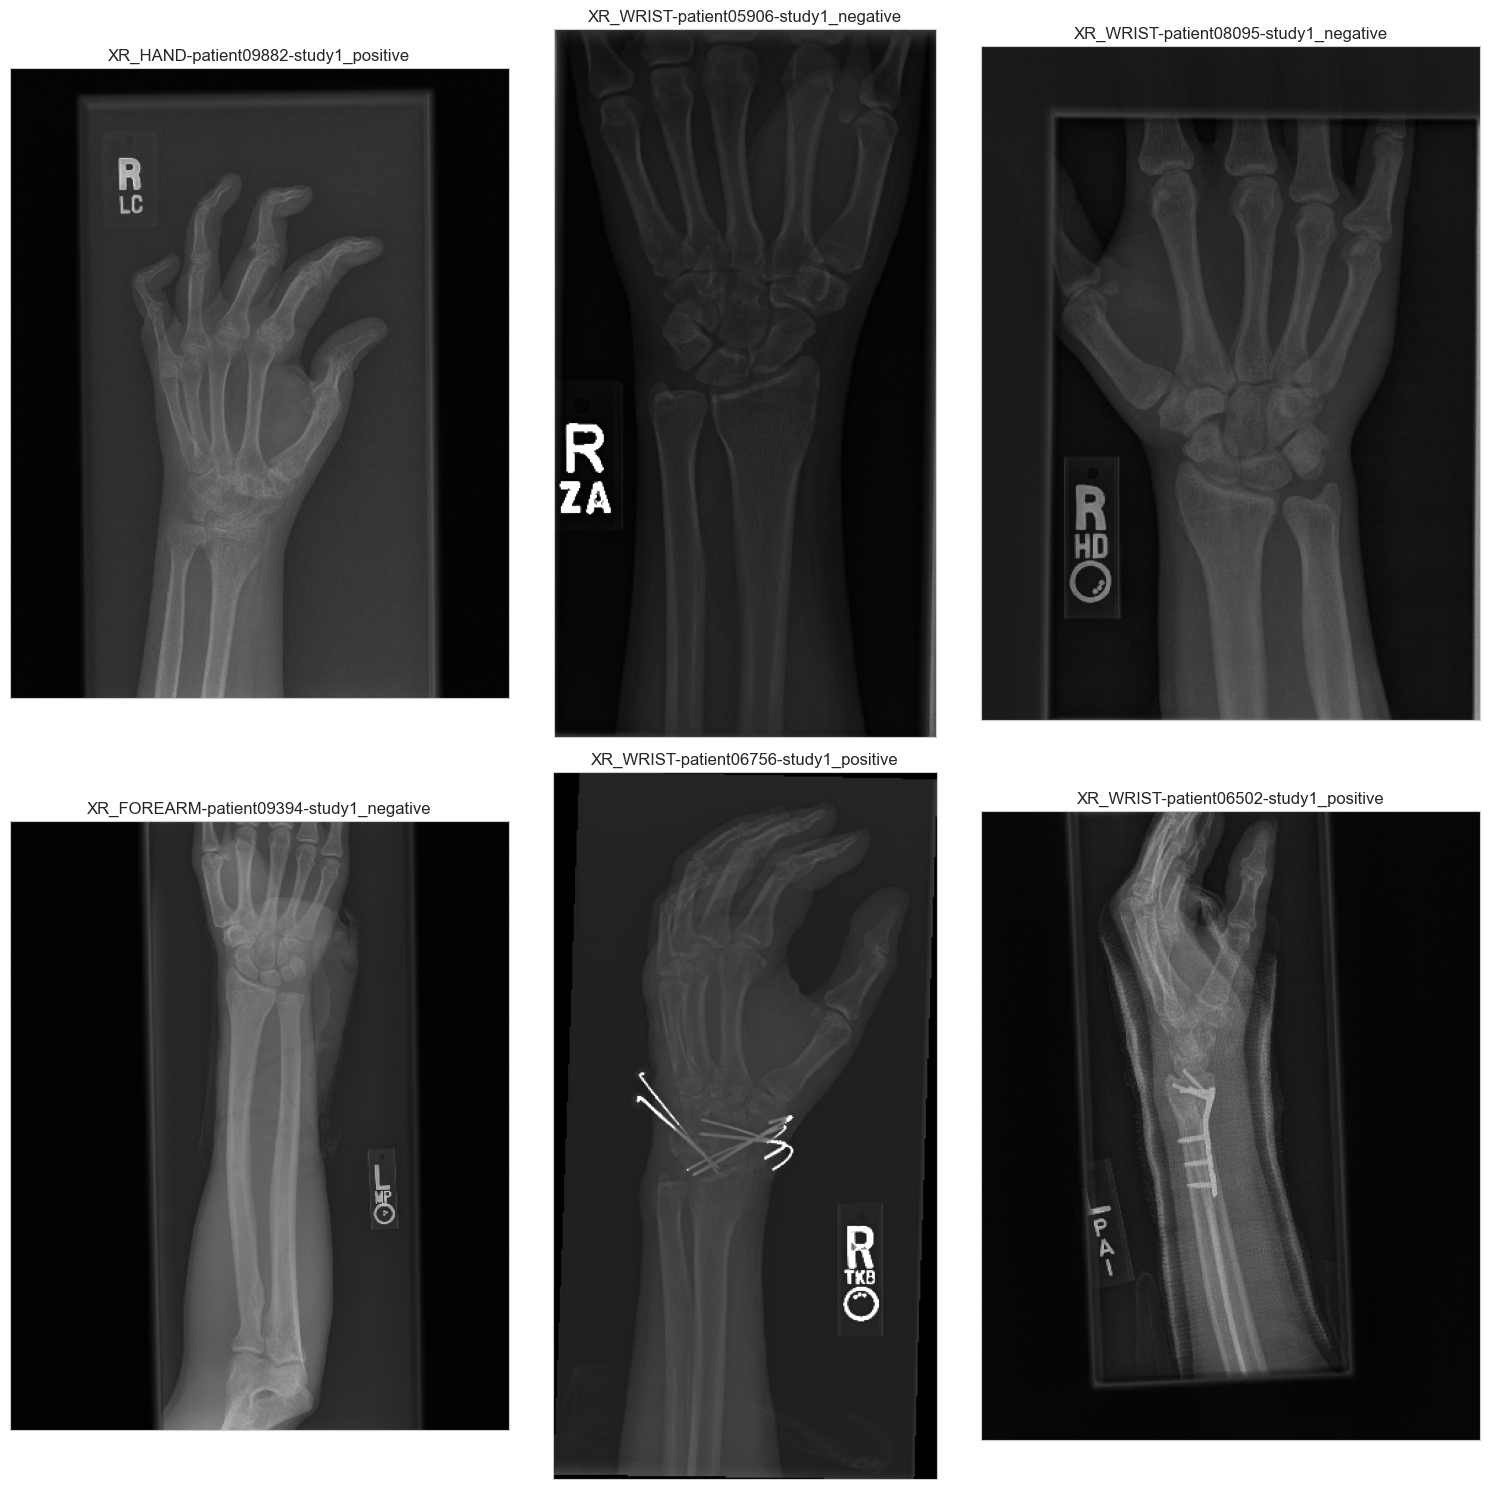

In [7]:
w, h = 10, 10
fig = plt.figure(figsize=(15, 15))
columns, rows = 3, 2
end, start = train_df.loc[0:].shape
ax = []
import random
for i in range(columns*rows):
    # img = np.array(Image.open(train_img_path.values[k][0]))
    k = random.randint(start, end)
    img = mpimg.imread((train_df.iloc[k,0]))
    title = (train_df.iloc[k,0]).split('/')
    title = title[2]+'-'+title[3]+'-'+title[4]
    k += 1
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(title)  # set title
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()  # finally, render the plot

**Prepare dataframes**

In [9]:
train_df['Label'] = train_df.apply(lambda x:1 if 'positive' in x.FilePath else 0, axis=1)
train_df['BodyPart'] = train_df.apply(lambda x: x.FilePath.split('/')[2][3:],axis=1)
train_df['StudyType'] = train_df.apply(lambda x: x.FilePath.split('/')[4][:6],axis=1)
valid_df['Label'] = valid_df.apply(lambda x:1 if 'positive' in x.FilePath else 0, axis=1)
valid_df['BodyPart'] = valid_df.apply(lambda x: x.FilePath.split('/')[2][3:],axis=1)
valid_df['StudyType'] = valid_df.apply(lambda x: x.FilePath.split('/')[4][:6],axis=1)

train_df.set_index(["FilePath", "BodyPart"]).groupby(level="BodyPart").count()
train_df.set_index(["FilePath", "Label"]).groupby(level="Label").count()

,BodyPart,StudyType
Label,,
0,21935,21935
1,14873,14873


**Vizualize Distribution**

AttributeError: 'numpy.int64' object has no attribute 'startswith'

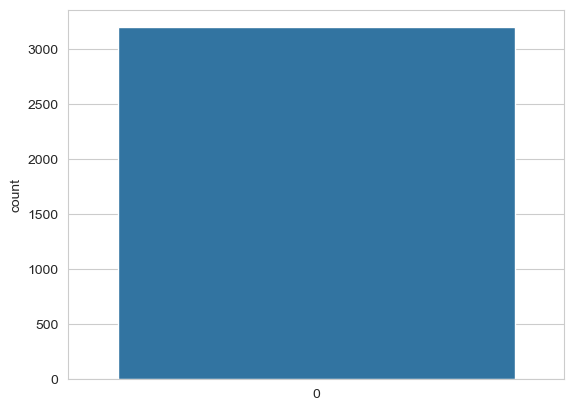

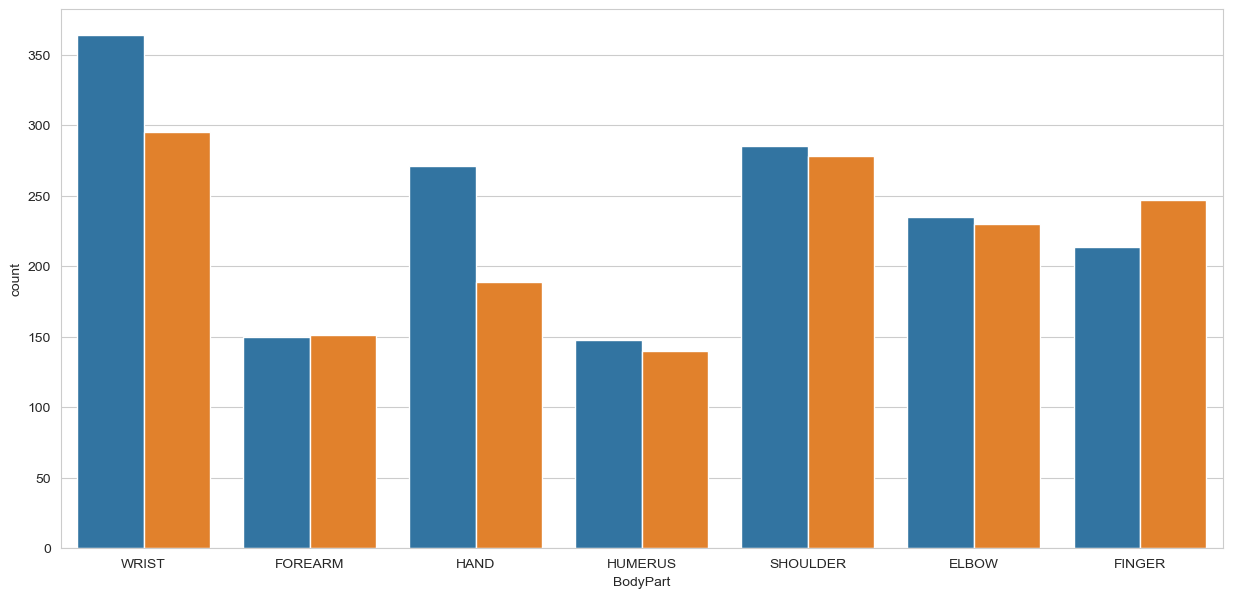

In [10]:
import seaborn as sns
sns.countplot(valid_df['Label'])
plt.figure(figsize=(15,7))
sns.countplot(data=valid_df,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=valid_df,x='StudyType',hue='Label')

**Custom Mura Dataset**

In [12]:
class MuraDataset(torch.utils.data.Dataset):
    
    def __init__(self,df,transform=None):
        self.df=df
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_name=self.df.iloc[idx,0]
        img=Image.open(img_name).convert('RGB')
        label=self.df.iloc[idx,1]
        if self.transform:
            img=self.transform(img)
        label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)
        return img, label
    
train_transform = transforms.Compose([
        transforms.Resize(256),
         transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])


**Prepare train and validation datasets**

In [13]:
train_dataset = MuraDataset(df=train_df,transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=0, shuffle=True)
val_dataset = MuraDataset(df=valid_df, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=0, shuffle=True)

In [15]:
for images, labels in train_loader:
    print(labels.shape)
    print(images.shape)
    break

torch.Size([32])
torch.Size([32, 3, 256, 256])


**Scaled down ResNet 50 Implementation**

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(512*4, num_classes)
        self.sigmoid = nn.Sigmoid()

        # Calculate the number of parameters
        self.num_parameters = sum(p.numel() for p in self.parameters())

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.sigmoid(self.linear(out))
        return out

def ResNet50():
    return ResNet(BasicBlock, [2, 3, 3, 1])

In [120]:
# Instantiate the ResNet50 model
resnet50_model = ResNet50()

**ResNet50 based model architecture with under 8 million parameters**

In [121]:
from torchsummary import summary

summary(resnet50_model, input_size=(2, 256, 256))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

In [122]:
resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

**Instantiate loss, optimizer and scheduler functions**

In [123]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
# The network was trained end-to-end using Adam with default parameters β1 = 0.9 and β2 = 0.999 
optimizer = optim.Adam(resnet50_model.parameters(), betas=(0.9,0.999), lr=0.0001)
# checking if cuda is available
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1)

**Train and validate model**

In [126]:
# Training and Validation Loop
import time
import copy
from tqdm import tqdm
since = time.time()
train_losses = []
valid_losses = []
num_epochs = 3
for epoch in range(num_epochs):
    # Training
    resnet50_model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.view(-1,1)
        optimizer.zero_grad()
        outputs = resnet50_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation
    resnet50_model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.view(-1,1)
            
            outputs = resnet50_model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.shape[0]
            predicted = torch.round(outputs)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.shape[0]

    # Calculate validation loss and accuracy
    val_loss = total_loss / total_samples
    val_acc = total_correct / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the Model
torch.save(resnet50_model.state_dict(), 'resnet50_model.pth')


Epoch [1/3], Val Loss: 0.6534, Val Acc: 0.6212
Epoch [2/3], Val Loss: 0.6309, Val Acc: 0.6362
Epoch [3/3], Val Loss: 0.7084, Val Acc: 0.5887
